## Sampling

In [1]:
import numpy as np
import pandas as pd
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample.csv")

In [2]:
df_sample['type'] = df_sample['type'].replace({'CASH_OUT': 0, 'CASH_IN': 1, 'PAYMENT': 2, 'TRANSFER': 3, 'DEBIT': 4})

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameDest'])
label
df_sample.drop("nameDest", axis=1, inplace=True)
df_sample["nameDest"] = label

le = LabelEncoder()
label = le.fit_transform(df_sample['nameOrig'])
label
df_sample.drop("nameOrig", axis=1, inplace=True)
df_sample["nameOrig"] = label

df_sample['type'] = df_sample['type'].replace({'CASH_OUT': 0, 'CASH_IN': 1, 'PAYMENT': 2, 'TRANSFER': 3, 'DEBIT': 4})

In [4]:
X = df_sample.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample['isFraud']

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# #Upsampling via SMOTE
# smote = SMOTE(sampling_strategy=0.4, random_state=0)

# #Downsample via RandomUnderSampler
# rus = RandomUnderSampler(sampling_strategy=0.9, random_state=0)

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.55, random_state=0)

#Application of the resampling methods
X_resampled, y_resampled = smote.fit_resample(X, y)
# X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)
# from imblearn.over_sampling import SMOTE

# #Upsampling via SMOTE
# smote = SMOTE(sampling_strategy=0.55, random_state=0)

# # Fit and apply the resampler to the entire dataset
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [6]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [7]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [8]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [9]:
# reverse_map = {0: 'CASH_OUT', 1: 'CASH_IN', 2: 'PAYMENT', 3: 'TRANSFER', 4: 'DEBIT'}
# df_sample['type'] = df_sample['type'].replace(reverse_map)

In [10]:
combined_data = pd.concat([X_train_resampled_final, y_train_resampled_final], axis=1)

In [11]:
reverse_map = {0: 'CASH_OUT', 1: 'CASH_IN', 2: 'PAYMENT', 3: 'TRANSFER', 4: 'DEBIT'}
combined_data ['type'] = combined_data ['type'].replace(reverse_map)

In [12]:
from sklearn.cluster import KMeans

# This code transforms the continuous variables (step and amount) taking into account ‘isFraud Class’ which is the objective  
# of this research. A k-means cluster model with 3 features, ‘isFraud’, ‘step’ and ‘amount’ is used.
# The variables ‘step_cluster’ and ‘amount_cluster’ are created for every single transaction.

continuous_vars = ['step','amount','isFraud']

# Normalizing the data
normalized_df = (combined_data[continuous_vars] - combined_data[continuous_vars].mean()) / combined_data[continuous_vars].std()

# Determining the optimal number of clusters
kmeans_kwargs = {"init": "random", "n_init": 15, "max_iter": 400, "random_state": 14}
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs,algorithm='full')
    kmeans.fit(normalized_df)
    sse.append(kmeans.inertia_)
    
# # Application of th elbow method 
# import matplotlib.pyplot as plt
# plt.style.use("fivethirtyeight")
# plt.plot(range(1, 11), sse)
# plt.xticks(range(1, 11))
# plt.xlabel("Number of Clusters")
# plt.ylabel("SSE")
# plt.show()

# Application of K-Means clustering
kmeans = KMeans(n_clusters=5, **kmeans_kwargs,algorithm='full',tol=0.0010)
kmeans.fit(normalized_df)
clusters = kmeans.predict(normalized_df)

# Using K-Means clustering to create clusters for the continuous variables "step", "amount" while taking "isFraud" into consideration
cluster_df = pd.DataFrame()
for var in continuous_vars:
    cluster_centers = kmeans.cluster_centers_[:, continuous_vars.index(var)]
    col_name = var + '_cluster'
    cluster_df[col_name] = kmeans.predict(normalized_df)
    
    # Replace cluster labels with desired values
    
    if var == 'isFraud':
        cluster_df[col_name] = cluster_df[col_name].apply(lambda x: 'Fraud' if x == 1 else 'No_Fraud')
  
    elif var=='amount':
        bin_edges = [0, 50000, 100000, 500000, 1000000, 5000000, 10000000, 60000000, 70000000]
        cluster_labels = ['0-50k', '50k-100k', '100k-500k', '500k-1M', '1M-5M', '5M-10M', '10M-60M', '60M-70M']
        cluster_df[col_name] = pd.cut(combined_data['amount'], bins=bin_edges, labels=cluster_labels)
   
    elif var == 'step':
        bin_edges = [1, 186, 372, 558, 743] 
        cluster_labels = ['1-186', '187-372', '373-558', '559-743']
        cluster_df[col_name] = pd.cut(combined_data['step'], bins=bin_edges, labels=cluster_labels)

# Create new dataframe to store the converted values
K_means_df = pd.DataFrame()
K_means_df = pd.concat([K_means_df, cluster_df], axis=1)

In [13]:
# from sklearn.metrics import silhouette_score

# silhouette_score = silhouette_score(normalized_df, clusters)
# print("Silhouette Score:", silhouette_score)

In [14]:
inertia = kmeans.inertia_
print("Inertia:", inertia)

Inertia: 501204.3137852309


In [15]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score = davies_bouldin_score(normalized_df, clusters)
print("Davies-Bouldin Index:", davies_bouldin_score)

Davies-Bouldin Index: 0.6610168411389796


In [16]:
K_means_df

,step_cluster,amount_cluster,isFraud_cluster
0,187-372,100k-500k,No_Fraud
1,187-372,100k-500k,No_Fraud
2,1-186,100k-500k,Fraud
3,187-372,0-50k,No_Fraud
4,187-372,0-50k,No_Fraud
...,...,...,...
1028103,1-186,0-50k,No_Fraud
1028104,373-558,1M-5M,No_Fraud
1028105,373-558,0-50k,No_Fraud
1028106,187-372,1M-5M,No_Fraud


In [17]:
from tabulate import tabulate
from termcolor import colored

# Get the counts for each cluster label
amount_cluster_counts = cluster_df['amount_cluster'].value_counts()
step_cluster_counts = cluster_df['step_cluster'].value_counts()
isFraud_cluster_counts = cluster_df['isFraud_cluster'].value_counts()

# Print the counts with labels
print(colored("Amount cluster counts:", 'blue'))
print(tabulate(amount_cluster_counts.to_frame().T, headers='keys', tablefmt='fancy_grid', numalign='center', stralign='center', colalign=("center",), showindex=False, disable_numparse=True))

print(colored("\nStep cluster counts:", 'blue'))
print(tabulate(step_cluster_counts.to_frame().T, headers='keys', tablefmt='fancy_grid', numalign='center', stralign='center', colalign=("center",), showindex=False, disable_numparse=True))

print(colored("\nIsFraud cluster counts:", 'blue'))
print(tabulate(isFraud_cluster_counts.to_frame().T, headers='keys', tablefmt='fancy_grid', numalign='center', stralign='center', colalign=("center",), showindex=False, disable_numparse=True))

Amount cluster counts:
╒═════════════╤═════════╤════════════╤═════════╤═══════════╤══════════╤═══════════╤═══════════╕
│  100k-500k  │  0-50k  │  50k-100k  │  1M-5M  │  500k-1M  │  5M-10M  │  10M-60M  │  60M-70M  │
╞═════════════╪═════════╪════════════╪═════════╪═══════════╪══════════╪═══════════╪═══════════╡
│   359855    │ 345976  │   101548   │  95698  │   82506   │  42251   │    270    │     3     │
╘═════════════╧═════════╧════════════╧═════════╧═══════════╧══════════╧═══════════╧═══════════╛

Step cluster counts:
╒═══════════╤═════════╤═══════════╤═══════════╕
│  187-372  │  1-186  │  373-558  │  559-743  │
╞═══════════╪═════════╪═══════════╪═══════════╡
│  431449   │ 292167  │  214975   │   89278   │
╘═══════════╧═════════╧═══════════╧═══════════╛

IsFraud cluster counts:
╒════════════╤═════════╕
│  No_Fraud  │  Fraud  │
╞════════════╪═════════╡
│   705215   │ 322893  │
╘════════════╧═════════╛


In [18]:
# Check the data types of columns after conversion
print(K_means_df.dtypes)

step_cluster       category
amount_cluster     category
isFraud_cluster      object
dtype: object


In [19]:
K_means_df= pd.concat([combined_data['type'].reset_index(drop=True), K_means_df], axis=1)

In [20]:
K_means_df

,type,step_cluster,amount_cluster,isFraud_cluster
0,CASH_IN,187-372,100k-500k,No_Fraud
1,CASH_OUT,187-372,100k-500k,No_Fraud
2,CASH_IN,1-186,100k-500k,Fraud
3,PAYMENT,187-372,0-50k,No_Fraud
4,PAYMENT,187-372,0-50k,No_Fraud
...,...,...,...,...
1028103,PAYMENT,1-186,0-50k,No_Fraud
1028104,TRANSFER,373-558,1M-5M,No_Fraud
1028105,TRANSFER,373-558,0-50k,No_Fraud
1028106,TRANSFER,187-372,1M-5M,No_Fraud


In [21]:
# Check the data types of columns after conversion
print(K_means_df .dtypes)

type                 object
step_cluster       category
amount_cluster     category
isFraud_cluster      object
dtype: object


In [22]:
# Change data types to object
K_means_df = K_means_df .astype('object')

# Check the data types of columns after conversion
print(K_means_df .dtypes)

type               object
step_cluster       object
amount_cluster     object
isFraud_cluster    object
dtype: object


### Split

In [23]:
X = K_means_df.drop('isFraud_cluster', axis=1)
# Separate the target variable
y = K_means_df['isFraud_cluster']

from sklearn.model_selection import train_test_split

# Print class distribution before split
print(y.value_counts(normalize=True))

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

No_Fraud    0.685935
Fraud       0.314065
Name: isFraud_cluster, dtype: float64
No_Fraud    0.685934
Fraud       0.314066
Name: isFraud_cluster, dtype: float64
No_Fraud    0.685938
Fraud       0.314062
Name: isFraud_cluster, dtype: float64


In [24]:
analysis_data = pd.concat([X_train, y_train], axis=1)

In [25]:
# test_data = pd.concat([X_test, y_test], axis=1)
test_data = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [26]:
# Change data types to object
K_means_df= K_means_df.astype('object')

[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...
-------------------------
finished in  12.65336561203003  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.47126846718326 % on  92529  instances
Labels:  ['Fraud' 'No_Fraud']
Confusion matrix:  [[18855, 2368], [10150, 61156]]
Precision:  88.8423 %, Recall:  65.006 %, F1:  75.0776 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...
-------------------------
finished in  13.00879716873169  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.55617938062996 % on  185059  instances
Labels:  ['Fraud' 'No_Fraud']
Confusion matrix:  [[37655, 4627], [20252, 122525]]
Precision:  89.0568 %, Recall:  65.0267 %, F1:  75.1679 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...
-------------------------
finished in  14.24551558494567

C:\Users\23059\anaconda3\envs\test2\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


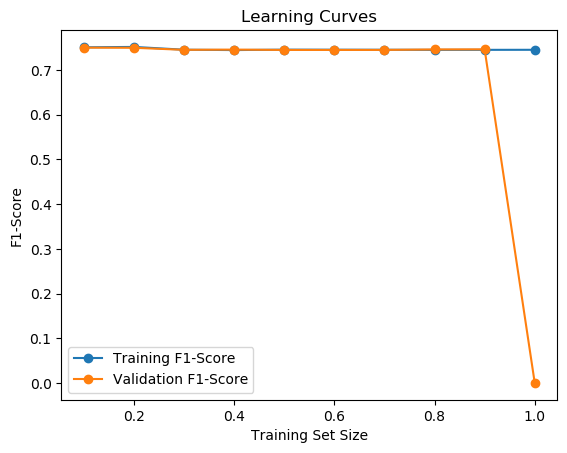

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from chefboost import Chefboost as chef

# Configure the model parameters
config = {
    'algorithm': 'CHAID',
    'learning_rate': 5.1,
    'enableParallelism': True,
    'max_depth': 8,
    'num_of_weak_classifier': 5,
    'enableRandomForest':False,
    'num_trees':3,
    'epochs':16,
    'enableMultitasking':True
}

# Store the sizes of the training set
train_sizes = np.linspace(0.1, 1.0, 10, endpoint=True)

# Initialize lists to store training and validation F1-scores
train_scores = []
val_scores = []

for train_size in train_sizes:
    # Calculate the number of samples for the current training set size
    num_samples = int(train_size * analysis_data.shape[0])

    # Split the data into training and validation sets
    train_data = analysis_data[:num_samples]
    val_data = analysis_data[num_samples:]

    # Train model
    model = chef.fit(train_data, config=config, target_label='isFraud_cluster')

    # Make predictions on the training set
    train_predictions = []
    for _, row in train_data.iterrows():
        prediction = chef.predict(model, row)
        train_predictions.append(prediction)

    # Make predictions on the validation set
    val_predictions = []
    for _, row in val_data.iterrows():
        prediction = chef.predict(model, row)
        val_predictions.append(prediction)

    # Calculate the F1-scores
    train_f1_score = f1_score(train_data['isFraud_cluster'], train_predictions, pos_label='Fraud', average='binary')
    val_f1_score = f1_score(val_data['isFraud_cluster'], val_predictions, pos_label='Fraud', average='binary')

    # Append the F1-scores to the lists
    train_scores.append(train_f1_score)
    val_scores.append(val_f1_score)

# Plot the learning curves
plt.plot(train_sizes, train_scores, 'o-', label='Training F1-Score')
plt.plot(train_sizes, val_scores, 'o-', label='Validation F1-Score')
plt.xlabel('Training Set Size')
plt.ylabel('F1-Score')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [28]:
# Predict for all rows in the test data
predictions = []
TP = 0  # True Positives
FP = 0  # False Positives
TN = 0  # True Negatives
FN = 0  # False Negatives

for i in range(len(test_data)):
    test_instance = test_data.iloc[i]
    prediction = chef.predict(model, test_instance)
    predictions.append(prediction)

   # Compare the prediction with the actual target value
    if prediction == "Fraud" and y_test.iloc[i] == "Fraud":
        TP += 1
    elif prediction == "Fraud" and y_test.iloc[i] == "No_Fraud":
        FP += 1
    elif prediction == "No_Fraud" and y_test.iloc[i] == "No_Fraud":
        TN += 1
    elif prediction == "No_Fraud" and y_test.iloc[i] == "Fraud":
        FN += 1

# Print the predictions
print(predictions)

# Print the counts for TP, FP, TN, and FN
print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)

['No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fr

In [29]:
# Calculate precision
precision = TP / (TP + FP)

# Calculate recall
recall = TP / (TP + FN)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.9095588887902725
Recall: 0.6347672581993868
F1 Score: 0.7477153749338781


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from chefboost import Chefboost as chef

# Configure the model parameters
config = {
    'algorithm': 'CHAID',
    'learning_rate': 3.7,
    'enableParallelism': True,
    'max_depth': 4,
    'num_of_weak_classifier': 6,
    'enableRandomForest':True,
    'num_trees':6,
    'epochs':3,
    'enableMultitasking':True
}

# Store the sizes of the training set
train_sizes = np.linspace(0.1, 1.0, 10, endpoint=True)

# Initialize lists to store training and validation F1-scores
train_scores = []
val_scores = []

for train_size in train_sizes:
    # Calculate the number of samples for the current training set size
    num_samples = int(train_size * analysis_data.shape[0])

    # Split the data into training and validation sets
    train_data = analysis_data[:num_samples]
    val_data = analysis_data[num_samples:]

    # Train model
    model = chef.fit(train_data, config=config, target_label='isFraud_cluster')

    # Make predictions on the training set
    train_predictions = []
    for _, row in train_data.iterrows():
        prediction = chef.predict(model, row)
        train_predictions.append(prediction)

    # Make predictions on the validation set
    val_predictions = []
    for _, row in val_data.iterrows():
        prediction = chef.predict(model, row)
        val_predictions.append(prediction)

    # Calculate the F1-scores
#     train_f1_score = f1_score(train_data['isFraud_cluster'], train_predictions, pos_label='Fraud', average='binary')
#     val_f1_score = f1_score(val_data['isFraud_cluster'], val_predictions, pos_label='Fraud', average='binary')
# Calculate the F1-scores
    train_f1_score = f1_score(train_data['isFraud_cluster'], train_predictions, pos_label='Fraud', average='binary', zero_division=1)
    val_f1_score = f1_score(val_data['isFraud_cluster'], val_predictions, pos_label='Fraud', average='binary', zero_division=1)

    # Append the F1-scores to the lists
    train_scores.append(train_f1_score)
    val_scores.append(val_f1_score)

# Plot the learning curves
plt.plot(train_sizes, train_scores, 'o-', label='Training F1-Score')
plt.plot(train_sizes, val_scores, 'o-', label='Validation F1-Score')
plt.xlabel('Training Set Size')
plt.ylabel('F1-Score')
plt.title('Learning Curves')
plt.legend()
plt.show()

[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


-------------------------
finished in  5.053791522979736  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.47126846718326 % on  92529  instances
Labels:  ['Fraud' 'No_Fraud']
Confusion matrix:  [[18855, 2368], [10150, 61156]]
Precision:  88.8423 %, Recall:  65.006 %, F1:  75.0776 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


-------------------------
finished in  6.99765682220459  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.55617938062996 % on  185059  instances
Labels:  ['Fraud' 'No_Fraud']
Confusion matrix:  [[37655, 4627], [20252, 122525]]
Precision:  89.0568 %, Recall:  65.0267 %, F1:  75.1679 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


-------------------------
finished in  7.133009672164917  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.49946503643876 % on  277589  instances
Labels:  ['Fraud' 'No_Fraud']
Confusion matrix:  [[54860, 5564], [31912, 185253]]
Precision:  90.7917 %, Recall:  63.2232 %, F1:  74.5401 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


-------------------------
finished in  7.66705322265625  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.43918966383694 % on  370118  instances
Labels:  ['Fraud' 'No_Fraud']
Confusion matrix:  [[73162, 7442], [42749, 246765]]
Precision:  90.7672 %, Recall:  63.1191 %, F1:  74.4594 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


-------------------------
finished in  7.316328048706055  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.47308536943854 % on  462648  instances
Labels:  ['Fraud' 'No_Fraud']
Confusion matrix:  [[91694, 9275], [53307, 308372]]
Precision:  90.814 %, Recall:  63.2368 %, F1:  74.5571 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


-------------------------
finished in  7.318188428878784  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.46488153349016 % on  555178  instances
Labels:  ['Fraud' 'No_Fraud']
Confusion matrix:  [[110045, 11107], [64037, 369989]]
Precision:  90.8322 %, Recall:  63.2145 %, F1:  74.5477 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


-------------------------
finished in  8.064013719558716  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.45961831507148 % on  647707  instances
Labels:  ['Fraud' 'No_Fraud']
Confusion matrix:  [[128351, 12958], [74744, 431654]]
Precision:  90.83 %, Recall:  63.1975 %, F1:  74.5351 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


IndentationError: unindent does not match any outer indentation level (outputs/rules/rule_4.py, line 5)

In [ ]:
# Predict for all rows in the test data
predictions = []
TP = 0  # True Positives
FP = 0  # False Positives
TN = 0  # True Negatives
FN = 0  # False Negatives

for i in range(len(test_data)):
    test_instance = test_data.iloc[i]
    prediction = chef.predict(model, test_instance)
    predictions.append(prediction)

   # Compare the prediction with the actual target value
    if prediction == "Fraud" and y_test.iloc[i] == "Fraud":
        TP += 1
    elif prediction == "Fraud" and y_test.iloc[i] == "No_Fraud":
        FP += 1
    elif prediction == "No_Fraud" and y_test.iloc[i] == "No_Fraud":
        TN += 1
    elif prediction == "No_Fraud" and y_test.iloc[i] == "Fraud":
        FN += 1

# Print the predictions
print(predictions)

# Print the counts for TP, FP, TN, and FN
print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)

# Calculate precision
precision = TP / (TP + FP)

# Calculate recall
recall = TP / (TP + FN)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)